In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys
import random
import numpy as np
import numpy.fft as nfft
from scipy.stats import norm
from scipy.signal import correlate
from scipy import interpolate
%matplotlib inline

# LOAD THE LIGHT CURVE FILES - THESE ARE FROM THE CATALINE SURVEYS DATA RELEASE 2 (CSDR2)

In [2]:
# load the light curve np files
target_lc = np.load("ts_datafile_100.npy")
lc_300 =  np.load("ts_datafile_300.npy")
lc_95 = np.load("ts_datafile_95.npy")
lc_124 = np.load("ts_datafile_124.npy")
lc_375 = np.load("ts_datafile_375.npy")
lc_868 = np.load("ts_datafile_868.npy")
lc_251 = np.load("ts_datafile_251.npy")
lc_64 = np.load("ts_datafile_64.npy")
lc_600 = np.load("ts_datafile_600.npy")
lc_654 = np.load("ts_datafile_654.npy")

# FOLD THE LIGHT CURVE, THEN INTERPOLATE FOR MISSING VALUES AND FINALLY STANDARDIZE

In [3]:
def standardize(ts, index_number, ts_id=None, ts_period=None):
    """fold, interpolate and standardize timeseries ts using its mean and std deviation"""
    
    # STEP 1 - FOLD THE LIGHT CURVES
    # fold the light curves
    period = ts_period;

    if (type(period)) is float :
        # divide by period to convert to phase
        foldTimes = ts[0] / float(period)
        # take fractional part of phase only (i.e. discard whole number part)
        foldTimes = foldTimes % 1
        ts = foldTimes, ts[1]

    # STEP 2 - INTERPOLATION
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d
    x = ts[0]
    y = ts[1]
    f = interpolate.interp1d(x, y, kind='linear')
    xnew = np.linspace(start=min(x), stop=max(x), num=300)
    ynew = f(xnew) # use interpolation function returned by `interp1d`

    xnew = xnew.tolist()
    ynew = ynew.tolist()

    interpolated_ats = xnew, ynew

    # the first index, for standardized cross corr.
    if (index_number == 1):
        stand_vals = (interpolated_ats[1] - np.mean(interpolated_ats[1]))/ np.std(interpolated_ats[1])
        
    return interpolated_ats[0], stand_vals

In [4]:
standardized_target_lc = standardize(target_lc, 1, ts_id=100, ts_period=0.366148) 
# plt.scatter(standardized_target_lc[0], standardized_target_lc[1])

In [5]:
standardized_lc_95 = standardize(lc_95, 1, ts_id=95, ts_period=0.334152) 
# plt.scatter(standardized_lc_95[0], standardized_lc_95[1])

In [6]:
standardized_lc_300 = standardize(lc_300, 1, ts_id=300, ts_period=0.313898)
# plt.scatter(standardized_lc_300[0], standardized_lc_300[1])

In [7]:
standardized_lc_124 = standardize(lc_124, 1, ts_id=124, ts_period=0.427902)
# plt.scatter(standardized_lc_124[0], standardized_lc_124[1])

In [8]:
standardized_lc_375 = standardize(lc_375, 1, ts_id=375, ts_period=0.282585)
# plt.scatter(standardized_lc_124[0], standardized_lc_124[1])

In [9]:
standardized_lc_868 = standardize(lc_868, 1, ts_id=868, ts_period=0.349604)
# plt.scatter(standardized_lc_124[0], standardized_lc_124[1])

In [10]:
standardized_lc_251 = standardize(lc_251, 1, ts_id=251, ts_period=0.413671)
# plt.scatter(standardized_lc_124[0], standardized_lc_124[1])

In [11]:
standardized_lc_64 = standardize(lc_64, 1, ts_id=64, ts_period=0.442856)
# plt.scatter(standardized_lc_124[0], standardized_lc_124[1])

In [12]:
standardized_lc_600 = standardize(lc_600, 1, ts_id=600, ts_period=0.379132)
# plt.scatter(standardized_lc_124[0], standardized_lc_124[1])

In [13]:
standardized_lc_654 = standardize(lc_654, 1, ts_id=654, ts_period=0.406918)
# plt.scatter(standardized_lc_124[0], standardized_lc_124[1])

# COMPUTE THE CROSS-CORRELATION SCORES AND DO PHASE SHIFTING 

In [14]:
def ccor(ts1, ts2):
    """
    given two standardized time series, compute their cross-correlation using FFT

    Args:
       ts1: first time series object
       ts2: second time series object
    Returns:
       Float - cross correlation value.

    Raises:
       ValueError: if length of ts1 and ts2 are not equal

    """
    # assert that len of ts1 = ts2
    if len(ts1[0]) != len(ts2[0]):

        # removed this temp. to make the longer ts file become the length of the shorter one
        raise ValueError("ts1 must be the same length as ts2 to calculate cross correlation")

    # fast fourier transform for ts1
    X = nfft.fft(ts1[1])

    # Complex conjugate of the fft transform of ts2
    Yhat = np.conjugate(nfft.fft(ts2[1]))

    # Normalizing scaler is required so that each shift is counted exactly once
    s = 1 / (1. * len(ts1[1]))

    return  (nfft.ifft(X * Yhat).real * s), (X * Yhat).real

def max_corr_at_phase(ts1, ts2):
    """ this is just for checking the max correlation with the kernelized cross-correlation """
    ccorts = ccor(ts1, ts2)
    idx = np.argmax(ccorts[0])
    maxcorr = ccorts[0][idx]

    return idx, maxcorr

def kernel_corr(ts1, ts2, mult=1):
    """
    Compute a kernelized correlation between two time series objects to be used as distance measure

    Args:
        ts1: first time series object. (Must be standardized.)
        ts2: second time series object. (Must be standardized.)
        m: multiplier factor. Defaults to 1. (Must be non-negative.)

    Returns:
        Float - kernelized correlation value

    The equation for the kernelized cross correlation is given at
    http://www.cs.tufts.edu/~roni/PUB/ecml09-tskernels.pdf
    normalize the kernel there by np.sqrt(K(x,x)K(y,y)) so that the correlation
    of a time series with itself is 1. We'll set the default multiplier to 1.
    """
    
    # calculate kernel
    kernel = np.sum(np.exp(mult * ccor(ts1, ts2)[0]))

    # Calculate kernel normalization constant:
    k_norm = np.sqrt(np.sum(np.exp(mult * ccor(ts1, ts1)[0])) *
                     np.sum(np.exp(mult * ccor(ts2, ts2)[0])))

    # return normalized kernel if k_norm is non-zero
    kernel_corr = kernel/k_norm if k_norm != 0 else 0
    return kernel_corr

def kernel_dist(ts1, ts2, mult=1):
    """
    Calculates a cross-correlation based distance between two time series objects.

    Args:
        ts1: 1st time series object. (Must be standardized)
        ts2: 2nd time series object. (Must be standardized)
        m: multiplier factor. Defaults to 1. (Must be non-negative.)

    Returns:
        Float: distance value
    """

    # Calculate the kernel correlation value for ts1 and ts2
    kernel_corr_val = kernel_corr(ts1,ts2, mult)

    # Theorem 1-P4 in Pavlos paper states that the dist^2 = C(ts1,ts1)+C(ts2,ts2)-2C(ts1,ts2)
    # (Where C = kernel correlation )
    # However, we are using normalized kernels here, so the dist^2 will be 2(1-C(ts1,ts2))
    return np.sqrt(2*(1-kernel_corr_val))

In [15]:
t=np.linspace(0.0, 1.0, num=300)
ccor(standardized_target_lc,standardized_lc_95)
max_corr = max_corr_at_phase(standardized_target_lc,standardized_lc_95)
shift_index = max_corr[0]
shifted_times_95 = list(map(lambda x: (x + t[shift_index]) % 1.0 , standardized_lc_95[0]))
shifted_lc_95 = np.array(shifted_times_95), lc_95[1]
standardized_shifted_lc_95 = shifted_times_95,standardized_lc_95[1] 

In [16]:
t=np.linspace(0.0, 1.0, num=300)
ccor(standardized_target_lc,standardized_lc_300)
max_corr = max_corr_at_phase(standardized_target_lc,standardized_lc_300)
shift_index = max_corr[0]
shifted_times_300 = list(map(lambda x: (x + t[shift_index]) % 1.0 , standardized_lc_300[0]))
shifted_lc_300 = np.array(shifted_times_300), lc_300[1]
standardized_shifted_lc_300 = shifted_times_300,standardized_lc_300[1] 

In [17]:
t=np.linspace(0.0, 1.0, num=300)
ccor(standardized_target_lc,standardized_lc_124)
max_corr = max_corr_at_phase(standardized_target_lc,standardized_lc_124)
shift_index = max_corr[0]
shifted_times_124 = list(map(lambda x: (x + t[shift_index]) % 1.0, standardized_lc_124[0]))
shifted_lc_124 = np.array(shifted_times_124), lc_124[1]
standardized_shifted_lc_124 = shifted_times_124,standardized_lc_124[1] 

In [18]:
t=np.linspace(0.0, 1.0, num=300)
ccor(standardized_target_lc,standardized_lc_375)
max_corr = max_corr_at_phase(standardized_target_lc,standardized_lc_375)
shift_index = max_corr[0]
shifted_times_375 = list(map(lambda x: (x + t[shift_index]) % 1.0, standardized_lc_375[0]))
shifted_lc_375 = np.array(shifted_times_375), lc_375[1]
standardized_shifted_lc_375 = shifted_times_375,standardized_lc_375[1] 

In [19]:
t=np.linspace(0.0, 1.0, num=300)
ccor(standardized_target_lc,standardized_lc_868)
max_corr = max_corr_at_phase(standardized_target_lc,standardized_lc_868)
shift_index = max_corr[0]
shifted_times_868 = list(map(lambda x: (x + t[shift_index]) % 1.0, standardized_lc_868[0]))
shifted_lc_868 = np.array(shifted_times_868), lc_868[1]
standardized_shifted_lc_868 = shifted_times_868,standardized_lc_868[1] 

In [20]:
t=np.linspace(0.0, 1.0, num=300)
ccor(standardized_target_lc,standardized_lc_251)
max_corr = max_corr_at_phase(standardized_target_lc,standardized_lc_251)
shift_index = max_corr[0]
shifted_times_251 = list(map(lambda x: (x + t[shift_index]) % 1.0, standardized_lc_251[0]))
shifted_lc_251 = np.array(shifted_times_251), lc_251[1]
standardized_shifted_lc_251 = shifted_times_251,standardized_lc_251[1] 

In [21]:
t=np.linspace(0.0, 1.0, num=300)
ccor(standardized_target_lc,standardized_lc_64)
max_corr = max_corr_at_phase(standardized_target_lc,standardized_lc_64)
shift_index = max_corr[0]
shifted_times_64 = list(map(lambda x: (x + t[shift_index]) % 1.0, standardized_lc_64[0]))
shifted_lc_64 = np.array(shifted_times_64), lc_64[1]
standardized_shifted_lc_64 = shifted_times_64,standardized_lc_64[1] 

In [22]:
t=np.linspace(0.0, 1.0, num=300)
ccor(standardized_target_lc,standardized_lc_600)
max_corr = max_corr_at_phase(standardized_target_lc,standardized_lc_600)
shift_index = max_corr[0]
shifted_times_600 = list(map(lambda x: (x + t[shift_index]) % 1.0, standardized_lc_600[0]))
shifted_lc_600 = np.array(shifted_times_600), lc_600[1]
standardized_shifted_lc_600 = shifted_times_600,standardized_lc_600[1] 

In [23]:
t=np.linspace(0.0, 1.0, num=300)
ccor(standardized_target_lc,standardized_lc_654)
max_corr = max_corr_at_phase(standardized_target_lc,standardized_lc_654)
shift_index = max_corr[0]
shifted_times_654 = list(map(lambda x: (x + t[shift_index]) % 1.0, standardized_lc_654[0]))
shifted_lc_654 = np.array(shifted_times_654), lc_654[1]
standardized_shifted_lc_654 = shifted_times_654,standardized_lc_654[1] 

# PLOT THE COMPARISONS

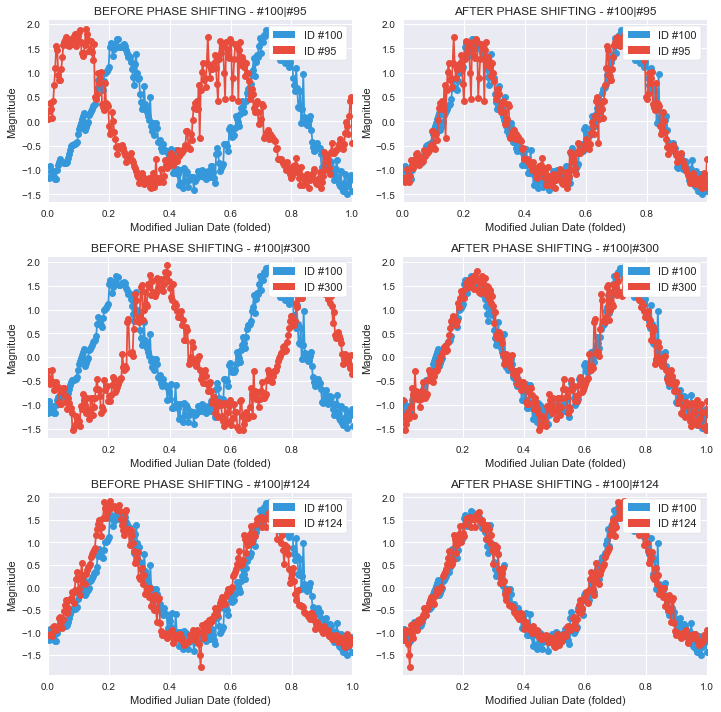

In [24]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

legend_names = ['ID #100', 'ID #95']
ax1 = sns.tsplot(time=standardized_target_lc[0], data=standardized_target_lc[1], color="#3498db", marker='o', ax=ax1)
ax1 = sns.tsplot(time=standardized_lc_95[0], data=standardized_lc_95[1], color="#e74c3c", marker='o', ax=ax1)

ax1.set(xlabel='Modified Julian Date (folded)',
       ylabel='Magnitude',
       title='BEFORE PHASE SHIFTING - #100|#95')

leg = ax1.legend(legend_names, loc="upper right", fontsize='11', facecolor='w', frameon=True, framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
legend_names = ['ID #100', 'ID #95']
ax2 = sns.tsplot(time=standardized_target_lc[0], data=standardized_target_lc[1], color="#3498db", marker='o', ax=ax2)
ax2 = sns.tsplot(time=standardized_shifted_lc_95[0], data=standardized_shifted_lc_95[1], color="#e74c3c", marker='o', ax=ax2)

ax2.set(xlabel='Modified Julian Date (folded)',
       ylabel='Magnitude',
       title='AFTER PHASE SHIFTING - #100|#95')

leg = ax2.legend(legend_names, loc="upper right", fontsize='11', facecolor='w', frameon=True, framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

legend_names = ['ID #100', 'ID #300']
ax3 = sns.tsplot(time=standardized_target_lc[0], data=standardized_target_lc[1], color="#3498db", marker='o',ax=ax3)
ax3 = sns.tsplot(time=standardized_lc_300[0], data=standardized_lc_300[1], color="#e74c3c", marker='o',ax=ax3)

ax3.set(xlabel='Modified Julian Date (folded)',
       ylabel='Magnitude',
       title='BEFORE PHASE SHIFTING - #100|#300')

leg = ax3.legend(legend_names, loc="upper right", fontsize='11', facecolor='w', frameon=True, framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
legend_names = ['ID #100', 'ID #300']
ax4 = sns.tsplot(time=standardized_target_lc[0], data=standardized_target_lc[1], color="#3498db", marker='o',ax=ax4)
ax4 = sns.tsplot(time=standardized_shifted_lc_300[0], data=standardized_shifted_lc_300[1], color="#e74c3c", marker='o',ax=ax4)

ax4.set(xlabel='Modified Julian Date (folded)',
       ylabel='Magnitude',
       title='AFTER PHASE SHIFTING - #100|#300')

leg = ax4.legend(legend_names, loc="upper right", fontsize='11', facecolor='w', frameon=True, framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
legend_names = ['ID #100', 'ID #124']
ax5 = sns.tsplot(time=standardized_target_lc[0], data=standardized_target_lc[1], color="#3498db", marker='o',ax=ax5)
ax5 = sns.tsplot(time=standardized_lc_124[0], data=standardized_lc_124[1], color="#e74c3c", marker='o',ax=ax5)

ax5.set(xlabel='Modified Julian Date (folded)',
       ylabel='Magnitude',
       title='BEFORE PHASE SHIFTING - #100|#124')

leg = ax5.legend(legend_names, loc="upper right", fontsize='11', facecolor='w', frameon=True, framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

legend_names = ['ID #100', 'ID #124']
ax6 = sns.tsplot(time=standardized_target_lc[0], data=standardized_target_lc[1], color="#3498db", marker='o',ax=ax6)
ax6 = sns.tsplot(time=standardized_shifted_lc_124[0], data=standardized_shifted_lc_124[1], color="#e74c3c", marker='o',ax=ax6)

ax6.set(xlabel='Modified Julian Date (folded)',
       ylabel='Magnitude',
       title='AFTER PHASE SHIFTING - #100|#124')

leg = ax6.legend(legend_names, loc="upper right", fontsize='11', facecolor='w', frameon=True, framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
fig.tight_layout()
plt.show()

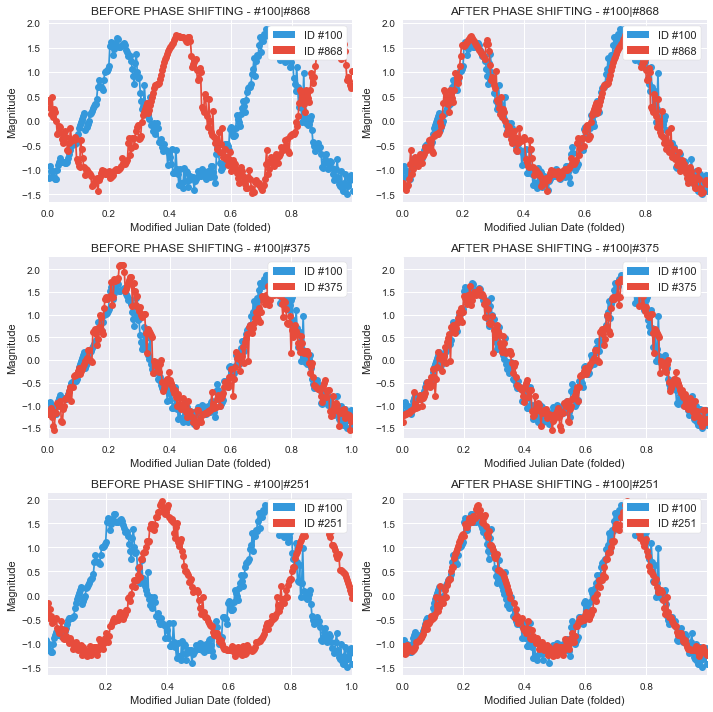

In [25]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

legend_names = ['ID #100', 'ID #868']
ax1 = sns.tsplot(time=standardized_target_lc[0], data=standardized_target_lc[1], color="#3498db", marker='o', ax=ax1)
ax1 = sns.tsplot(time=standardized_lc_868[0], data=standardized_lc_868[1], color="#e74c3c", marker='o', ax=ax1)

ax1.set(xlabel='Modified Julian Date (folded)',
       ylabel='Magnitude',
       title='BEFORE PHASE SHIFTING - #100|#868')

leg = ax1.legend(legend_names, loc="upper right", fontsize='11', facecolor='w', frameon=True, framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
legend_names = ['ID #100', 'ID #868']
ax2 = sns.tsplot(time=standardized_target_lc[0], data=standardized_target_lc[1], color="#3498db", marker='o', ax=ax2)
ax2 = sns.tsplot(time=standardized_shifted_lc_868[0], data=standardized_shifted_lc_868[1], color="#e74c3c", marker='o', ax=ax2)

ax2.set(xlabel='Modified Julian Date (folded)',
       ylabel='Magnitude',
       title='AFTER PHASE SHIFTING - #100|#868')

leg = ax2.legend(legend_names, loc="upper right", fontsize='11', facecolor='w', frameon=True, framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

legend_names = ['ID #100', 'ID #375']
ax3 = sns.tsplot(time=standardized_target_lc[0], data=standardized_target_lc[1], color="#3498db", marker='o',ax=ax3)
ax3 = sns.tsplot(time=standardized_lc_375[0], data=standardized_lc_375[1], color="#e74c3c", marker='o',ax=ax3)

ax3.set(xlabel='Modified Julian Date (folded)',
       ylabel='Magnitude',
       title='BEFORE PHASE SHIFTING - #100|#375')

leg = ax3.legend(legend_names, loc="upper right", fontsize='11', facecolor='w', frameon=True, framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
legend_names = ['ID #100', 'ID #375']
ax4 = sns.tsplot(time=standardized_target_lc[0], data=standardized_target_lc[1], color="#3498db", marker='o',ax=ax4)
ax4 = sns.tsplot(time=standardized_shifted_lc_375[0], data=standardized_shifted_lc_375[1], color="#e74c3c", marker='o',ax=ax4)

ax4.set(xlabel='Modified Julian Date (folded)',
       ylabel='Magnitude',
       title='AFTER PHASE SHIFTING - #100|#375')

leg = ax4.legend(legend_names, loc="upper right", fontsize='11', facecolor='w', frameon=True, framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
legend_names = ['ID #100', 'ID #251']
ax5 = sns.tsplot(time=standardized_target_lc[0], data=standardized_target_lc[1], color="#3498db", marker='o',ax=ax5)
ax5 = sns.tsplot(time=standardized_lc_251[0], data=standardized_lc_251[1], color="#e74c3c", marker='o',ax=ax5)

ax5.set(xlabel='Modified Julian Date (folded)',
       ylabel='Magnitude',
       title='BEFORE PHASE SHIFTING - #100|#251')

leg = ax5.legend(legend_names, loc="upper right", fontsize='11', facecolor='w', frameon=True, framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

legend_names = ['ID #100', 'ID #251']
ax6 = sns.tsplot(time=standardized_target_lc[0], data=standardized_target_lc[1], color="#3498db", marker='o',ax=ax6)
ax6 = sns.tsplot(time=standardized_shifted_lc_251[0], data=standardized_shifted_lc_251[1], color="#e74c3c", marker='o',ax=ax6)

ax6.set(xlabel='Modified Julian Date (folded)',
       ylabel='Magnitude',
       title='AFTER PHASE SHIFTING - #100|#251')

leg = ax6.legend(legend_names, loc="upper right", fontsize='11', facecolor='w', frameon=True, framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
fig.tight_layout()
plt.show()

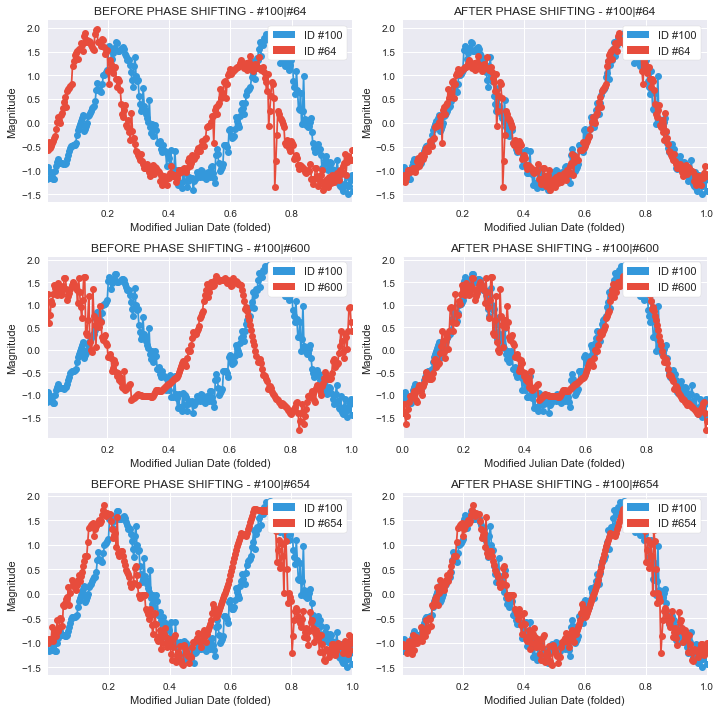

In [26]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

legend_names = ['ID #100', 'ID #64']
ax1 = sns.tsplot(time=standardized_target_lc[0], data=standardized_target_lc[1], color="#3498db", marker='o', ax=ax1)
ax1 = sns.tsplot(time=standardized_lc_64[0], data=standardized_lc_64[1], color="#e74c3c", marker='o', ax=ax1)

ax1.set(xlabel='Modified Julian Date (folded)',
       ylabel='Magnitude',
       title='BEFORE PHASE SHIFTING - #100|#64')

leg = ax1.legend(legend_names, loc="upper right", fontsize='11', facecolor='w', frameon=True, framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
legend_names = ['ID #100', 'ID #64']
ax2 = sns.tsplot(time=standardized_target_lc[0], data=standardized_target_lc[1], color="#3498db", marker='o', ax=ax2)
ax2 = sns.tsplot(time=standardized_shifted_lc_64[0], data=standardized_shifted_lc_64[1], color="#e74c3c", marker='o', ax=ax2)

ax2.set(xlabel='Modified Julian Date (folded)',
       ylabel='Magnitude',
       title='AFTER PHASE SHIFTING - #100|#64')

leg = ax2.legend(legend_names, loc="upper right", fontsize='11', facecolor='w', frameon=True, framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

legend_names = ['ID #100', 'ID #600']
ax3 = sns.tsplot(time=standardized_target_lc[0], data=standardized_target_lc[1], color="#3498db", marker='o',ax=ax3)
ax3 = sns.tsplot(time=standardized_lc_600[0], data=standardized_lc_600[1], color="#e74c3c", marker='o',ax=ax3)

ax3.set(xlabel='Modified Julian Date (folded)',
       ylabel='Magnitude',
       title='BEFORE PHASE SHIFTING - #100|#600')

leg = ax3.legend(legend_names, loc="upper right", fontsize='11', facecolor='w', frameon=True, framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
legend_names = ['ID #100', 'ID #600']
ax4 = sns.tsplot(time=standardized_target_lc[0], data=standardized_target_lc[1], color="#3498db", marker='o',ax=ax4)
ax4 = sns.tsplot(time=standardized_shifted_lc_600[0], data=standardized_shifted_lc_600[1], color="#e74c3c", marker='o',ax=ax4)

ax4.set(xlabel='Modified Julian Date (folded)',
       ylabel='Magnitude',
       title='AFTER PHASE SHIFTING - #100|#600')

leg = ax4.legend(legend_names, loc="upper right", fontsize='11', facecolor='w', frameon=True, framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
legend_names = ['ID #100', 'ID #654']
ax5 = sns.tsplot(time=standardized_target_lc[0], data=standardized_target_lc[1], color="#3498db", marker='o',ax=ax5)
ax5 = sns.tsplot(time=standardized_lc_654[0], data=standardized_lc_654[1], color="#e74c3c", marker='o',ax=ax5)

ax5.set(xlabel='Modified Julian Date (folded)',
       ylabel='Magnitude',
       title='BEFORE PHASE SHIFTING - #100|#654')

leg = ax5.legend(legend_names, loc="upper right", fontsize='11', facecolor='w', frameon=True, framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

legend_names = ['ID #100', 'ID #654']
ax6 = sns.tsplot(time=standardized_target_lc[0], data=standardized_target_lc[1], color="#3498db", marker='o',ax=ax6)
ax6 = sns.tsplot(time=standardized_shifted_lc_654[0], data=standardized_shifted_lc_654[1], color="#e74c3c", marker='o',ax=ax6)

ax6.set(xlabel='Modified Julian Date (folded)',
       ylabel='Magnitude',
       title='AFTER PHASE SHIFTING - #100|#654')

leg = ax6.legend(legend_names, loc="upper right", fontsize='11', facecolor='w', frameon=True, framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
fig.tight_layout()
plt.show()